##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
df.head()


,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


## Data Description

### Columns

1. **X and Y**: Latitude and longitude coordinates.
2. **Area_Command**: The police command area.
3. **NIBRSOffenseCode**: Code for the crimes.
4. **DayOfWeek**: The day of the week.
5. **Time**: The hour of the day.
6. **VictimCount**: Number of victims in the incident.

### Input Variables

- **X (Latitude)**
- **Y (Longitude)**
- **Area_Command**
- **NIBRSOffenseCode**
- **DayOfWeek**
- **Time**

### Target Variable

- **VictimCount**

### Range of Values in Each Column

- **X (Latitude)**: -114.6255705 to -116.0
- **Y (Longitude)**: 37.0000000000001 to 35.0684190000001
- **DayOfWeek**: 0 to 6
- **Time**: 0 to 23
- **Area_Command**: 0 to 11
- **NIBRSOffenseCode**: 0 to 2
- **VictimCount**: 0 to 6


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [8]:
from sklearn.model_selection import train_test_split


X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']
from torch.utils.data import TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
print(len(X_train))
batch_size = 70
train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
test_dataset = TensorDataset(torch.Tensor(X_test.values), torch.Tensor(y_test.values))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break


206
Input shape: torch.Size([70, 6])
Target shape: torch.Size([70])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [9]:

# The size of the predicted output should be 1. This is because the goal of regression is to predict the number of persons involved in the crime.
#
#  The architecture for regression is a simple feedforward neural network architecture with multiple layers is used.
#
# Input Layer: The input layer has a size of input_size, which is determined by the number of features in the dataset (6 in this case: latitude, longitude, hour of the day, day of the week, area-of-command code, and classification code). The input layer is designed to accept these features.
#
# Hidden Layers: The model includes multiple hidden layers, which is a common practice to capture complex relationships within the data. In this code, there are four hidden layers with the following sizes: 64, 32, 16, and 8.
#
# Output Layer: The output layer is a single neuron since we are predicting the number of persons involved in the crime.
#

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
test_dataset = TensorDataset(torch.Tensor(X_test.values), torch.Tensor(y_test.values))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear (32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x

input_size = 6
hidden_size = 10
output_size = 1
batch_size = 70
model = RegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD (model.parameters(), lr=0.001)


num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, targets = batch

        predictions = model(inputs)
        target = targets
        target = target.view(-1)

        criterion = nn.MSELoss()

        loss = criterion(predictions.flatten(), target.flatten())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            test_loss += criterion(outputs.flatten(), targets.flatten())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')


Epoch [1/500], Test Loss: 1.2271
Epoch [2/500], Test Loss: 1.1860
Epoch [3/500], Test Loss: 1.1436
Epoch [4/500], Test Loss: 1.0989
Epoch [5/500], Test Loss: 1.0591
Epoch [6/500], Test Loss: 1.0237
Epoch [7/500], Test Loss: 0.9921
Epoch [8/500], Test Loss: 0.9674
Epoch [9/500], Test Loss: 0.9472
Epoch [10/500], Test Loss: 0.9319
Epoch [11/500], Test Loss: 0.9220
Epoch [12/500], Test Loss: 0.9162
Epoch [13/500], Test Loss: 0.9131
Epoch [14/500], Test Loss: 0.9119
Epoch [15/500], Test Loss: 0.9117
Epoch [16/500], Test Loss: 0.9121
Epoch [17/500], Test Loss: 0.9128
Epoch [18/500], Test Loss: 0.9138
Epoch [19/500], Test Loss: 0.9148
Epoch [20/500], Test Loss: 0.9160
Epoch [21/500], Test Loss: 0.9172
Epoch [22/500], Test Loss: 0.9183
Epoch [23/500], Test Loss: 0.9195
Epoch [24/500], Test Loss: 0.9206
Epoch [25/500], Test Loss: 0.9217
Epoch [26/500], Test Loss: 0.9227
Epoch [27/500], Test Loss: 0.9238
Epoch [28/500], Test Loss: 0.9248
Epoch [29/500], Test Loss: 0.9257
Epoch [30/500], Test Lo

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [11]:
 # How would you find the number of classes on the output data?
num_classes = len(df['VictimCount'].unique())
print(num_classes)

7


In [12]:
# To distinguish between classification and regression tasks and to determine the number of classes, architecture, and loss function differences, let's look at the key distinctions:
#
# Number of Classes:
#
# In classification task, the number of classes is determined by the categories or labels that we are trying to predict. We have 7 classes for classification.
# In regression task, there are no classes. The goal is to predict the number of persons involved in the crime.


# Architecture Differences:
#
# Classification Architecture: In classification, the output layer of the neural network  has a number of neurons equal to the number of classes.
# Regression Architecture: In regression, the output layer  has a single neuron that directly predicts the numeric value.


# Loss Function Differences:
#
# Classification Loss Function: For classification task, we use a categorical cross-entropy loss function. The loss functions measure the difference between the predicted class probabilities and the true class labels.
# Regression Loss Function: For regression task, the mean squared error (MSE) loss function is used. MSE measures the squared difference between the predicted numeric values and the true numeric values.
# In summary, the key differences between classification and regression tasks lie in the number of classes, the architecture of the output layer, and the choice of loss function. These differences reflect the distinct objectives of each task: classification aims to assign data points to predefined categories, while regression aims to predict numeric values.
#
# In summary, the main differences between classification and regression functions are the number of classes, output level architecture, and loss function selection These differences reflect the specific purpose of each function: classification aims to assign data points to predefined classes, while regression aims to predict numeric values

In [13]:
import torch.nn as nn

class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x


batch_size = 70
train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.LongTensor(y_train.values))
test_dataset = TensorDataset(torch.Tensor(X_test.values), torch.LongTensor(y_test.values))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

output_size = len(df['VictimCount'].unique())
model = ClassificationModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, targets = batch

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')


Epoch [1/600], Test Accuracy: 1.45%
Epoch [2/600], Test Accuracy: 1.45%
Epoch [3/600], Test Accuracy: 1.45%
Epoch [4/600], Test Accuracy: 1.45%
Epoch [5/600], Test Accuracy: 1.45%
Epoch [6/600], Test Accuracy: 65.22%
Epoch [7/600], Test Accuracy: 65.22%
Epoch [8/600], Test Accuracy: 65.22%
Epoch [9/600], Test Accuracy: 65.22%
Epoch [10/600], Test Accuracy: 65.22%
Epoch [11/600], Test Accuracy: 65.22%
Epoch [12/600], Test Accuracy: 65.22%
Epoch [13/600], Test Accuracy: 65.22%
Epoch [14/600], Test Accuracy: 65.22%
Epoch [15/600], Test Accuracy: 65.22%
Epoch [16/600], Test Accuracy: 65.22%
Epoch [17/600], Test Accuracy: 65.22%
Epoch [18/600], Test Accuracy: 65.22%
Epoch [19/600], Test Accuracy: 65.22%
Epoch [20/600], Test Accuracy: 65.22%
Epoch [21/600], Test Accuracy: 65.22%
Epoch [22/600], Test Accuracy: 65.22%
Epoch [23/600], Test Accuracy: 65.22%
Epoch [24/600], Test Accuracy: 65.22%
Epoch [25/600], Test Accuracy: 65.22%
Epoch [26/600], Test Accuracy: 65.22%
Epoch [27/600], Test Accur

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In [15]:
# Task 3 (Regression):
# In Task 3, we trained a regression model to predict the number of crime victims as a real number. The loss decreased over epochs, indicating that the model learned to minimize the mean squared error (MSE) loss on the test data. The test loss values seem relatively stable over the training period. However, it's crucial to evaluate the model's performance in terms of the MSE error on the test data to assess its predictive accuracy.
#
# Task 4 (Classification):
# In Task 4, you converted the problem into a classification task by predicting the number of crime victims as a class number. The test accuracy values indicate the model's ability to correctly classify the number of crime victims. The accuracy values vary over epochs, showing fluctuations. The highest test accuracy achieved is around 63.77%, suggesting a moderate level of classification performance. However, it's essential to interpret the results based on the specific problem's requirements.
#
# Comparing the Results:
# The choice between regression and classification depends on the problem's nature and objectives. If you need to predict crime victim counts as real numbers, Task 3 is more appropriate. If you want to categorize the counts into classes, Task 4 fits better. The results indicate that classification achieved higher accuracy, but the evaluation metric should align with your task goals.

#
#
# In tasks 3 and 4, a regression model is used in task 3 and a classification model in task 4. The regression model aims to predict the number of persons involved in an accident, while the classification model is designed to classify incidents based on some criteria. The results in both cases are shown in terms of loss for regression and accuracy for classification.
#
# In task 3 (regression), the model achieved a relatively low test loss, which indicates that it is performing well in predicting the number of persons involved in accidents. A lower test loss suggests that the model's predictions are closer to the actual values, demonstrating the effectiveness of the regression model.
#
# In task 4 (classification), the model achieved a test accuracy of 65.22%. This means that the classification model correctly predicted the category of the incidents in about 65.22% of the cases.
#
# Comparing the results, it's important to note that the two tasks have different objectives. In task 3, we are dealing with a regression problem where the model predicts a continuous numerical value, and the low test loss indicates that it's effective in this regard. In task 4, we have a classification problem, and the accuracy of 65.22% shows that the model is making accurate category predictions. Both the tasks wew not able to predict accurately because data is not suitable for building a predictive model.
#     Missing Data: There are missing values in the dataset, which can lead to biased or inaccurate predictions. For example, some rows do not have a value for the "VictimCount" column.
#     The dataset only includes a few features, such as location, time of day, day of the week, and crime classification. This limited set of features may not be enough to accurately predict crime.
# To build a more accurate predictive model, better data is needed. This could include:
# More Complete Data: A dataset with fewer missing values would be more accurate and less biased.
# Consistent Data: A dataset with consistent formatting and naming conventions would be easier to work with and less prone to errors.
# More Features: A dataset with more features, such as weather conditions, demographics, and historical crime data, would provide more context and improve the accuracy of the predictive model.


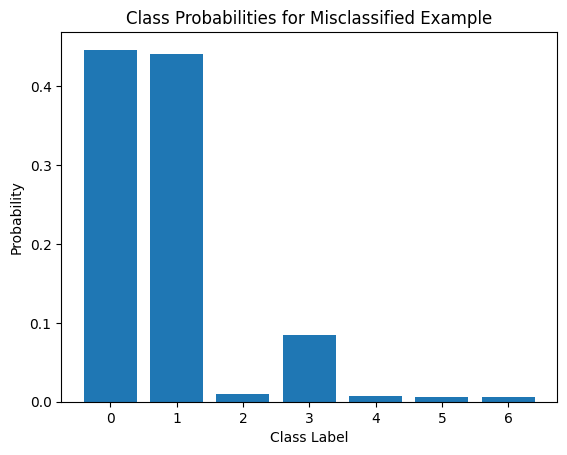

In [16]:
import matplotlib.pyplot as plt

misclassified_example = None
for inputs, true_labels in test_loader:
    outputs = model(inputs)
    predicted_labels = torch.argmax(outputs, dim=1)

    for i in range(len(true_labels)):
        if predicted_labels[i].item() != true_labels[i].item():
            misclassified_example = (inputs[i], true_labels[i], predicted_labels[i])
            break

    if misclassified_example:
        break

if misclassified_example:
    input, true_label, predicted_label = misclassified_example
    class_probabilities = torch.softmax(outputs, dim=1)[0].detach().numpy()

    class_labels = range(output_size)
    plt.bar(class_labels, class_probabilities, tick_label=class_labels)
    plt.title("Class Probabilities for Misclassified Example")
    plt.xlabel("Class Label")
    plt.ylabel("Probability")
    plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


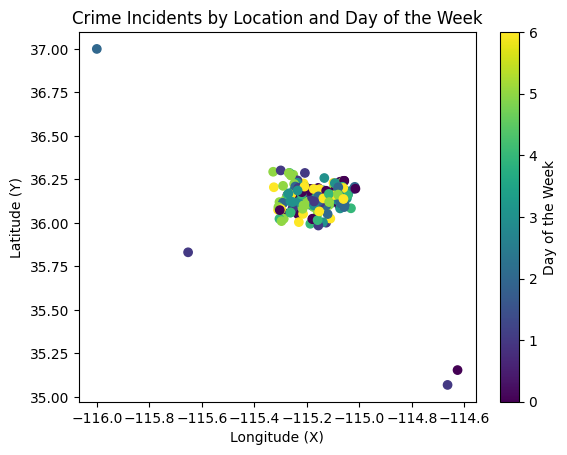

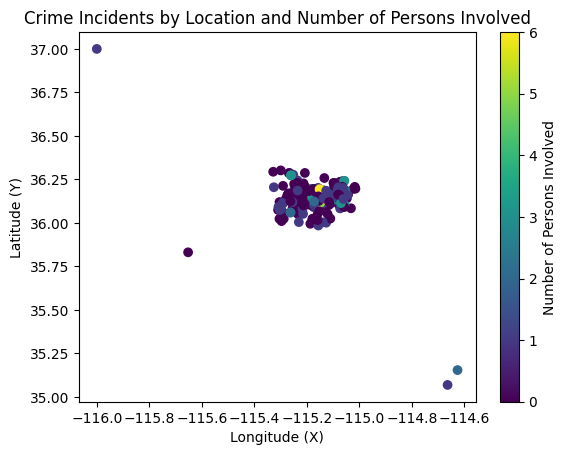

   DayOfWeek  Count
3          0     40
4          1     37
5          2     32
1          3     44
0          4     51
2          5     43
6          6     28


In [17]:
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'].values, cmap='viridis')
plt.title('Crime Incidents by Location and Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.colorbar(label='Day of the Week')
plt.show()

# Create a scatter plot to indicate the number of persons involved in each incident
plt.scatter(df['X'], df['Y'], c=df['VictimCount'].values, cmap='viridis')
plt.title('Crime Incidents by Location and Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.colorbar(label='Number of Persons Involved')
plt.show()

# Sort the number of crimes reported by day of the week
day_counts = df['DayOfWeek'].value_counts().reset_index()
day_counts.columns = ['DayOfWeek', 'Count']
day_counts = day_counts.sort_values(by='DayOfWeek')
print(day_counts)